# Project1 - Crash Data Montgomery County, MD

By: Heidy Togliatti & Mathias Lund Ahrn


In this project we will explore vehicle crash data from Montgomery County in Maryland. The data is collected from the Automated Crash Report System of the Maryland State Police. 

#### Our goals
- Explore the relation between:
    - substance abuse, driver at fault
    - speed limit, vehicle model year

(We will primarily look at accidents related in different speed limits, what vehicle body type and model year)

### About the dataset
**Name**: Crash Reporting - Drivers Data

**State**: Maryland, MD

**County**: Montgomery

**Last updated**: October 10th 2019

**Date created**: Septemeber 19th 2017

**Dataset Owner**: MCG ESB Service

Data acquired October 15th 2019, hosted on [GitHub](https://raw.githubusercontent.com/CruddyShad0w/CST-383-CrashData/master/Crash_Reporting_-_Drivers_Data.csv) by [Kyle Hays](https://github.com/CruddyShad0w/CST-383-CrashData/).


In [1]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

In [2]:
# Added to remove in and out in the margin

#%%HTML
#<style>
#div.prompt {display:none}
#</style>

### Sneakpeak of the dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from matplotlib import rcParams
import seaborn as sns
sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk')

In [4]:
url = "https://raw.githubusercontent.com/CruddyShad0w/CST-383-CrashData/master/Crash_Reporting_-_Drivers_Data.csv"

df = pd.read_csv(url)

df.set_index(pd.to_datetime(df['Crash Date/Time']), inplace=True)
df.sort_index(ascending=True, inplace=True)

df.info()

/Users/certinax/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100148 entries, 2015-01-01 00:30:00 to 2019-10-09 20:30:00
Data columns (total 43 columns):
Report Number                     100148 non-null object
Local Case Number                 100148 non-null object
Agency Name                       100148 non-null object
ACRS Report Type                  100148 non-null object
Crash Date/Time                   100148 non-null object
Route Type                        90559 non-null object
Road Name                         91015 non-null object
Cross-Street Type                 90549 non-null object
Cross-Street Name                 91011 non-null object
Off-Road Description              9132 non-null object
Municipality                      10943 non-null object
Related Non-Motorist              3028 non-null object
Collision Type                    99813 non-null object
Weather                           92279 non-null object
Surface Condition                 88280 non-null object
Light       

Firstly, converting Crash Date/Time into pandas datetime and set it as index. This is useful for later operations on the data.

##### Quick Facts:
- Number of rows: 100 148
- Number of columns: 43
- Each row is a driver

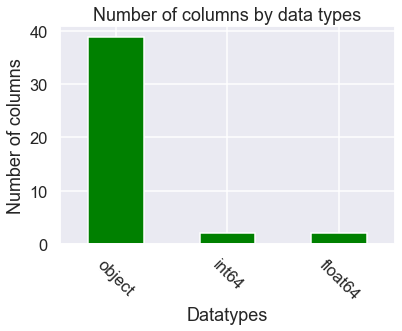

In [5]:
barplot = df.dtypes.value_counts().plot.bar(color="green");
plt.title("Number of columns by data types")
plt.xlabel("Datatypes")
plt.ylabel("Number of columns")
plt.xticks(rotation=-45)
plt.show(barplot)

In [6]:
df.describe().round()

,Speed Limit,Vehicle Year,Latitude,Longitude
count,100148.0,100148.0,100148.0,100148.0
mean,33.0,1970.0,39.0,-77.0
std,11.0,331.0,0.0,0.0
min,0.0,0.0,38.0,-79.0
25%,30.0,2004.0,39.0,-77.0
50%,35.0,2009.0,39.0,-77.0
75%,40.0,2014.0,39.0,-77.0
max,70.0,9999.0,40.0,-76.0


Further investigation of the numeric columns shows weird data. We have minimum and maximum values for *Vehicle Year* that does not make sense. Below is a distribution of all the reported vehicles with 

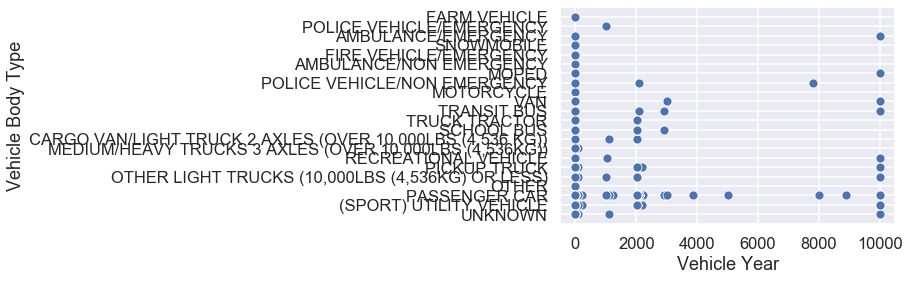

In [7]:
#df[(df["Vehicle Year"] > 2019) | (df["Vehicle Year"] < 1900)]["Vehicle Year"].value_counts().sort_index()
data = df[(df["Vehicle Year"] > 2019) | (df["Vehicle Year"] < 1900)]
sns.scatterplot(x=data["Vehicle Year"], y=data["Vehicle Body Type"]);

# Data exploration

The scatterplot above doesn't neccessarily tell too much, other than there are several vehicles registered with a model year to 0 and way above year 2020. To make this more clear, we divide the year range into three reasonable ranges, 0-1899, 1900-2020 and 2021+. When we plot this, we see that most of the reports have reasonable model years, but alot of the reports have model year 0. This is useful exploration when the data cleaning begins.

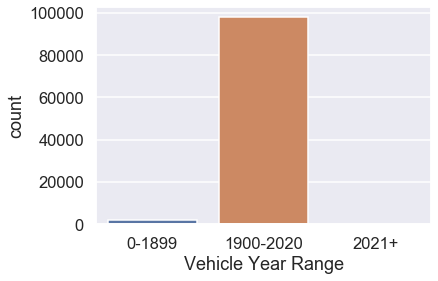

In [8]:
bins = [-1, 1899, 2020, np.inf]
names = ['0-1899', '1900-2020', '2021+']

df['Vehicle Year Range'] = pd.cut(df['Vehicle Year'], bins, labels=names)
#df.info()
#df[df["Vehicle Year Range"] == "2020+"]["Vehicle Year"].value_counts().sort_index()
data = df["Vehicle Year Range"].value_counts().sort_index()
#print(data.sum())
#print(df[(df["Vehicle Year"] >= 0) & (df["Vehicle Year"] <= 1899)].shape)
#print(df[df["Vehicle Year Range"].isna()]["Vehicle Year"])
#print(df[df["Vehicle Year Range"] == "0-1899"]["Vehicle Year")]
#df[df["Vehicle Year"] == 2020].index
sns.countplot(df["Vehicle Year Range"]);
#sns.scatterplot(data=df, hue=data)
#sns.barplot(x=df["Vehicle Year Range"], data=df)
#print(df[df["Vehicle Year Range"].isna()]["Vehicle Year"])

#print(df.dtypes.value_counts())
#df.info()
#grid = sns.FacetGrid(df["Vehicle Year Range"], row=df["Speed Limit"], col=df["Driver At Fault"])
#grid.map(plt.hist)

### Accessing specific years
## df["2015"]

#### Number of entries

Each row is represented as a 'driver'/vehicle. At first glance, it might look that each entry represents an unique accident. When doing a counting for the *Report Number* series, there is clearly several entries with same Report Number. 

In [9]:
print(df["Report Number"].value_counts().head(3))

MCP12130045    9
MCP2667000H    8
MCP2617006L    7
Name: Report Number, dtype: int64


#### Number of entries with duplicated report numbers:

In [10]:
print(df["Report Number"].value_counts().value_counts().sort_index())

1    17309
2    33578
3     4064
4      689
5      112
6       17
7        8
8        1
9        1
Name: Report Number, dtype: int64


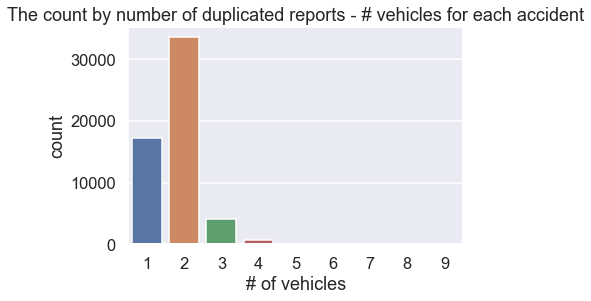

In [11]:
reports = df["Report Number"].value_counts()
reportplot = sns.countplot(reports)
plt.title("The count by number of duplicated reports - # vehicles for each accident")
plt.xlabel("# of vehicles")
plt.show(reportplot)

With further investigation of the data, we can see that there are different *Vehicle ID's* for all entries sharing same *Report Number*. With this information in mind, the plot above tells that most of the accidents involves two vehicles. /// HER SKAL DET LAGES PLOT FOR PROSENTVIS AV ANTALL ULYKKER HVOR MANGE SOM ER INVOLVERT

In [12]:
#numVehicles = df["Report Number"].value_counts().value_counts()
#percentNumInvolved = numVehicles/df["Report Number"].unique().shape[0]
#print(numVehicles)
#print(percentNumInvolved)

In [13]:
#substanceMask = ~df["Driver Substance Abuse"].isin(["NONE DETECTED", "UNKNOWN", np.nan])
#print(substanceMask.value_counts())
#df[df["Driver Substance Abuse"].isin()]["Driver At Fault"].value_counts()
#print(df[substanceMask]["Driver At Fault"].value_counts())

### Data Cleaning

Columns of interest; [Driver at Fault], [Vehicle Year], [Speed Limi], [Vehicle Body Type]

Clearing all data that is not to be used for this report.

In [14]:
df.drop(columns=['Local Case Number', 'Agency Name',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Type',
       'Cross-Street Name', 'Off-Road Description', 'Municipality',
       'Related Non-Motorist', 'Collision Type', 'Weather',
       'Surface Condition', 'Light', 'Traffic Control', 'Non-Motorist Substance Abuse', 'Person ID',
      'Injury Severity', 'Circumstance',
       'Driver Distracted By', 'Drivers License State', 'Vehicle ID',
       'Vehicle Damage Extent', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location',
       'Vehicle Movement', 'Vehicle Continuing Dir', 'Vehicle Going Dir',
        'Driverless Vehicle', 'Parked Vehicle',
       'Vehicle Make', 'Vehicle Model', 'Equipment Problems', 'Latitude',
       'Longitude', 'Location', "Vehicle Year Range"], inplace=True)

#### Vehicle Year

Focuses on 1980-present as there are few values below this year that are valid. The plot below shows the distribution of cars based on year of make.

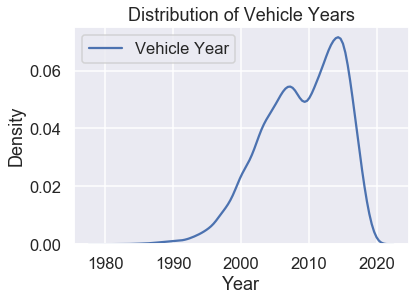

In [15]:
df = df[(df["Vehicle Year"] >= 1980) & (df["Vehicle Year"] <= 2020)]
yearDist = sns.kdeplot(df["Vehicle Year"], bw=.8);
plt.title("Distribution of Vehicle Years")
plt.xlabel("Year")
plt.ylabel("Density")
plt.show(yearDist)

#### Driver Substance Abuse

Looking at the values for driver substance abuse there are these categories. And there are a number of N/A values that will be dropped. Values belonging to *UNKNOWN* will also be dropped.

In [16]:
df["Driver Substance Abuse"].value_counts()

NONE DETECTED                 71675
UNKNOWN                        4470
ALCOHOL PRESENT                2325
ALCOHOL CONTRIBUTED             859
ILLEGAL DRUG PRESENT            171
MEDICATION PRESENT               71
COMBINED SUBSTANCE PRESENT       46
ILLEGAL DRUG CONTRIBUTED         45
MEDICATION CONTRIBUTED           42
OTHER                            32
COMBINATION CONTRIBUTED          24
Name: Driver Substance Abuse, dtype: int64

In [17]:
substanceMask = ~df["Driver Substance Abuse"].isin(["UNKNOWN", np.nan])
df = df[substanceMask]

#### Vehicle Body Type

There is a small number of N/A values in this column as well as a few *UNKNOWN* values. These will be dropped.

In [18]:
df["Vehicle Body Type"].isna().sum()

64

In [19]:
df["Vehicle Body Type"].isin(["UNKNOWN"]).sum()

42

In [20]:
bodyTypeMask = ~df["Vehicle Body Type"].isin(["UNKNOWN", np.nan])
df = df[bodyTypeMask]

In [21]:
driverAtFaultMask = ~df["Driver At Fault"].isin(["Unknown"])
df = df[driverAtFaultMask]

### Problems

Are older cars more prone to accidents than newer cars?

In [22]:
df.describe().round()

,Speed Limit,Vehicle Year
count,73585.0,73585.0
mean,34.0,2009.0
std,10.0,6.0
min,0.0,1980.0
25%,30.0,2005.0
50%,35.0,2010.0
75%,40.0,2014.0
max,70.0,2020.0


In [23]:
bins = [1979, 1989, 1999, 2009, 2019, 2029]
names = ["80's", "90's", "00's", "10's", "20's"]
df["decades"] = pd.cut(df["Vehicle Year"], bins, labels=names)

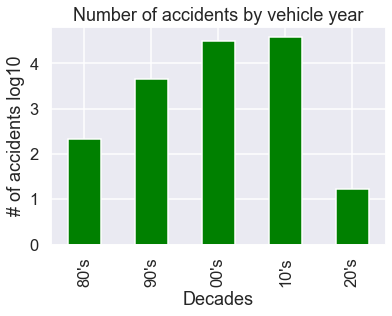

In [24]:
carPlot = df["decades"].value_counts().sort_index().apply(np.log10).plot.bar(color="green")
plt.title("Number of accidents by vehicle year")
plt.xlabel("Decades")
plt.ylabel("# of accidents log10")
plt.show(carPlot)

This plot shows that there seems to be more accidents for cars in the 00's and 10's. However there are alot more these cars than some of the others.

#### Are older cars responsible for more accidents than newer cars?

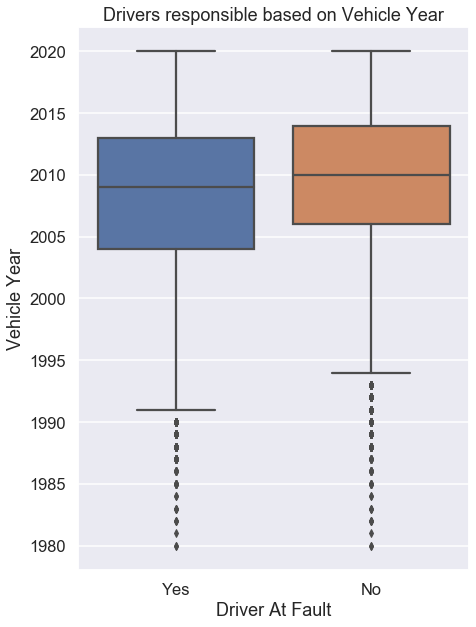

In [25]:
plt.figure(figsize = (7,10))
sns.boxplot(y="Vehicle Year", x="Driver At Fault", data=df);
plt.title("Drivers responsible based on Vehicle Year");

From the graph it does indeed look like there are more drivers with older cars that are responsible for accidents. However the difference is not very significant. But the median for drivers responsible is definitely at a lower vehicle year.

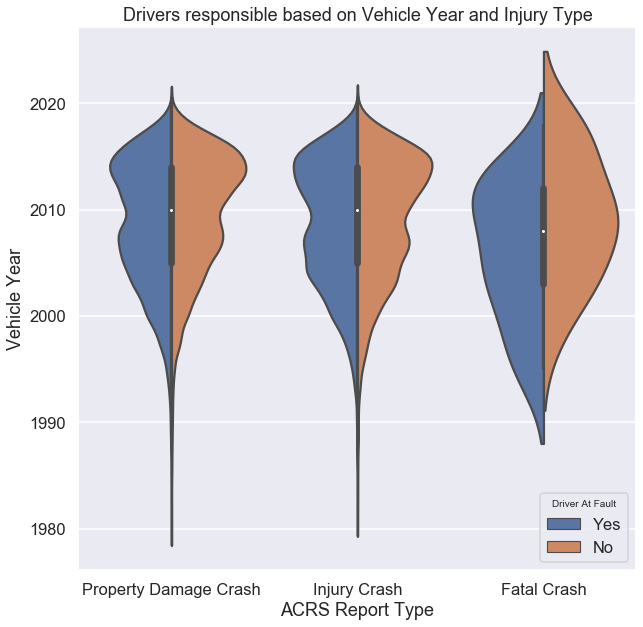

In [26]:
plt.figure(figsize = (10,10))
sns.violinplot(y="Vehicle Year", x="ACRS Report Type", hue="Driver At Fault", split=True, data=df, legend=False);
plt.legend(loc="lower right", title="Driver At Fault")
plt.title("Drivers responsible based on Vehicle Year and Injury Type");

This graph is showing correlation between drivers at fault, vehicle year and injury type. It shows us the same information as in the previous plot where it seems that there is a marginally bigger probability that a driver responsible will drive an older car. However in this plot information is displayed about the different injury types and it seems like there is a bigger difference in fatal crashes than in the other two. It is worth noting that we have relatively few values for fatal crashes.

#### Number of accidents during holidays, July 4th and December 24th

In order to deal with specific dates, creating a new column with normalized dates makes it way easier.

In [27]:
df["Normalized date"] = df.index.normalize()

['2015' '2016' '2017' '2018' '2019']


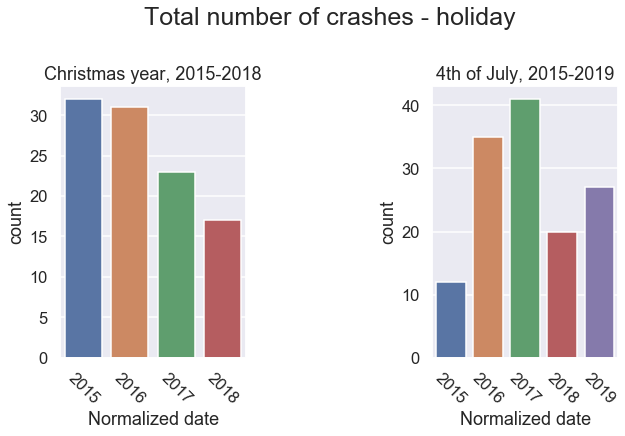

In [28]:
years = df.index.year.unique()

christmas = pd.date_range("2015-12-24", periods=(years.size-1), freq=pd.DateOffset(months=12, day=24))
fourthJuly = pd.date_range("2015-07-04", periods=years.size, freq=pd.DateOffset(months=12, day=4))


christmas_crashes = df[df["Normalized date"].isin(christmas)].drop_duplicates("Report Number")
fourthJuly_crashes = df[df["Normalized date"].isin(fourthJuly)]

christDf = pd.DataFrame(christmas_crashes.groupby("Normalized date").size()).reset_index()
christDf.rename({0:"count"}, axis="columns", inplace=True)

#christmas_plot = sns.countplot(x="ACRS Report Type",data=christmas_crashes)


#christmas_crashes["label"] = 
#print(christmas_crashes["Normalized date"].apply(strftime('%Y')))
#print(christmas_crashes["label"])
christmas_labels = df["Normalized date"].apply(lambda x: x.strftime("%Y")).unique()
fourthJuly_labels = df["Normalized date"].apply(lambda x: x.strftime("%Y")).unique()
y_pos = np.arange(len(christmas_labels))
print(christmas_labels)

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x="Normalized date", data=christmas_crashes, ax=ax[0])
sns.countplot(x="Normalized date", data=fourthJuly_crashes, ax=ax[1])
fig.suptitle("Total number of crashes - holiday", size=25, y=1.1)
ax[0].set_title("Christmas year, 2015-2018")
#ax[0].set_xlabel(christmas_labels)
ax[1].set_title("4th of July, 2015-2019")
#ax[0].set_xticks(rotation=-90);
plt.subplots_adjust(wspace=1)
#plt.xticks(y_pos, christmas_labels)
ax[0].set_xticklabels(christmas_labels, rotation=-45)
ax[1].set_xticklabels(christmas_labels, rotation=-45)
plt.show()
#sns.countplot(christmas_crashes)
#sns.countplot(fourthJuly_crashes)

In [29]:
#g = sns.FacetGrid(christDf, col='Normalized date', height=4, aspect=0.8)
#colors=["red","darkred","yellow","blue","green","orange"]
#g.map(plt.hist, x="Normalized date", color='green')

#### Lets look at number of crashes each month compared anually

Text(0.5, 0, 'Months')

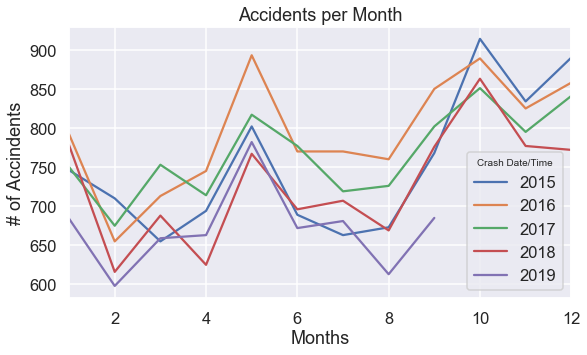

In [30]:
fig, plot = plt.subplots(figsize=(9,5))

collisions = df.drop_duplicates('Report Number')
collisions = collisions["2015":"2019-09-30"]

collisions.groupby([collisions.index.month , collisions.index.year]).count()['Report Number'].unstack().plot(ax=plot)
plt.title('Accidents per Month')
plt.ylabel('# of Accindents')
plt.xlabel('Months')

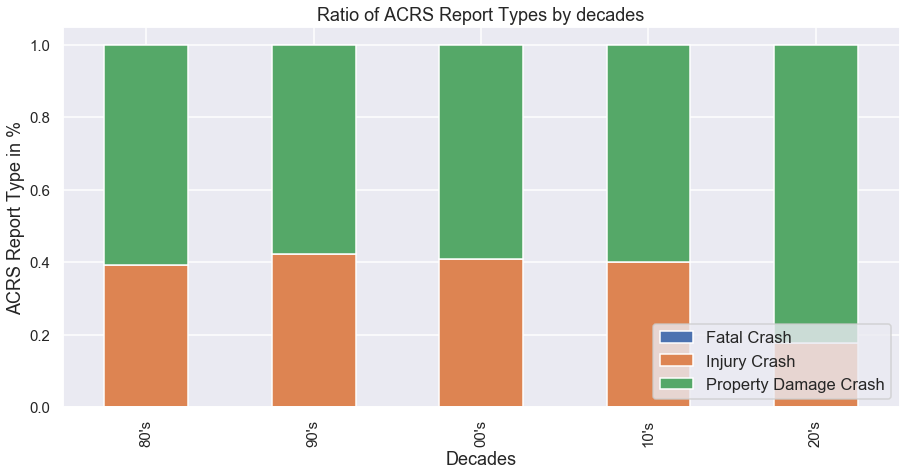

In [81]:
def calcPercent(x):
    return x.groupby("ACRS Report Type").size()/x["ACRS Report Type"].shape[0]

percents = df.groupby("decades").apply(calcPercent)
crashPercentage = pd.DataFrame(percents).reset_index()

crashPercentage.rename({0:"ReportType.perc"}, axis="columns", inplace=True)

pivot_df = crashPercentage.pivot(index='decades', columns='ACRS Report Type', values='ReportType.perc').replace(np.nan, 0)
pivot_df.plot.bar(stacked=True, figsize=(15,7));
plt.title("Ratio of ACRS Report Types by decades");
plt.xlabel("Decades");
plt.ylabel("ACRS Report Type in %");
plt.legend(loc="lower right")
plt.xticks(size=15);
plt.yticks(size=15); 

In [83]:
df.columns

Index(['Report Number', 'ACRS Report Type', 'Driver Substance Abuse',
       'Driver At Fault', 'Vehicle Body Type', 'Speed Limit', 'Vehicle Year',
       'decades', 'Normalized date'],
      dtype='object')

In [84]:
df["Driver At Fault"].value_counts()

Yes    38609
No     34976
Name: Driver At Fault, dtype: int64